In [2]:
import os
import yaml
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt as edt

In [1]:
MAP_NAME = "levine_closed_static_obstacle_2"

TRACK_WIDTH_MARGIN = 0.0

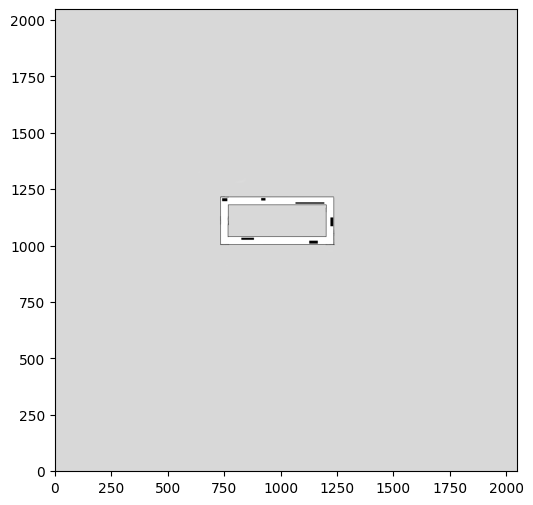

In [19]:
if os.path.exists(f"../maps/{MAP_NAME}.png"):
    map_img_path = f"../maps/{MAP_NAME}.png"

map_yaml_path = f"../maps/{MAP_NAME}.yaml"
raw_map_img = np.array(Image.open(map_img_path).transpose(Image.FLIP_TOP_BOTTOM))
raw_map_img = raw_map_img.astype(np.float64)

plt.figure(figsize=(6, 6))
plt.imshow(raw_map_img, cmap='gray', origin='lower')
plt.show()

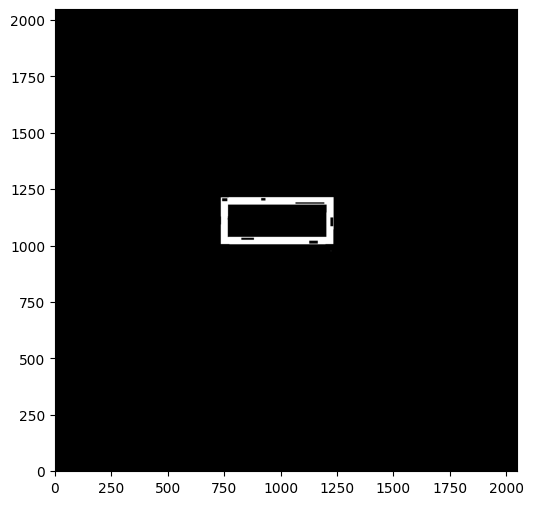

In [20]:
map_img = raw_map_img.copy()
map_img[map_img <= 220.] = 0
map_img[map_img > 220.] = 1

plt.figure(figsize=(6, 6))
plt.imshow(map_img, cmap='gray', origin='lower')
plt.show()

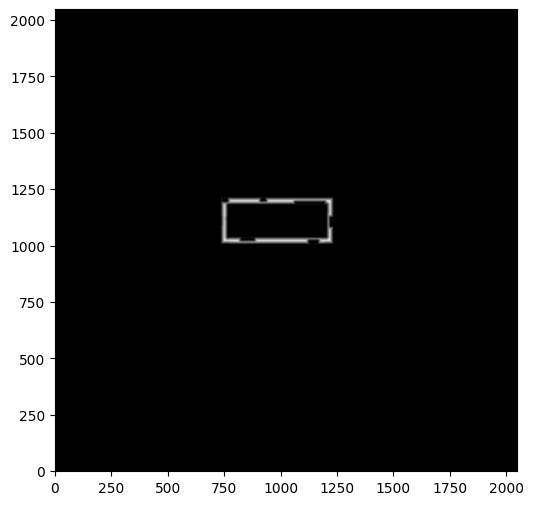

In [21]:
dist_transform = edt(map_img)

plt.figure(figsize=(6, 6))
plt.imshow(dist_transform, cmap='gray', origin='lower')
plt.show()

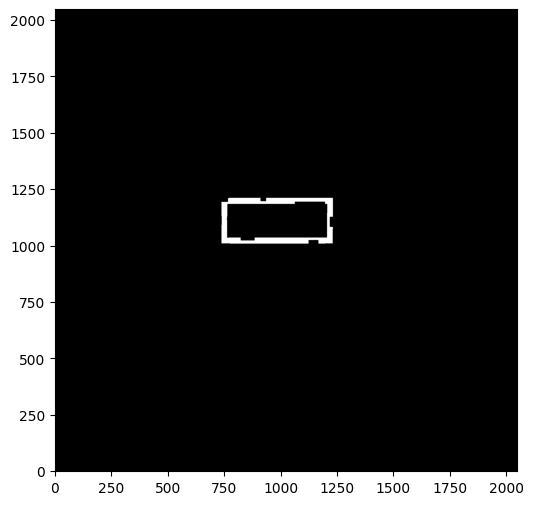

In [22]:
THRESHOLD = 0.2 
centers = dist_transform > THRESHOLD*dist_transform.max()

plt.figure(figsize=(6, 6))
plt.imshow(centers, origin='lower', cmap='gray')
plt.show()

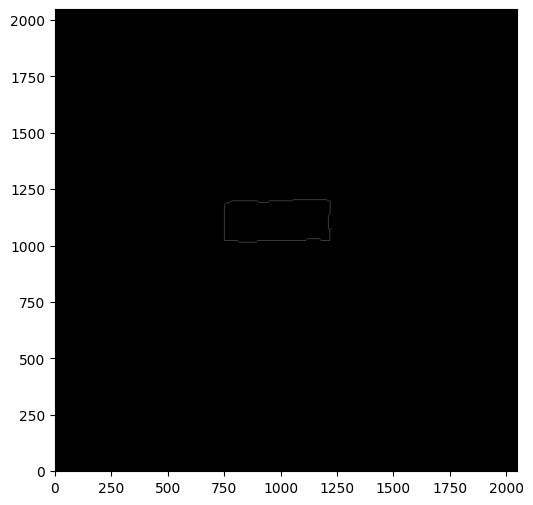

In [23]:
centerline = skeletonize(centers)

plt.figure(figsize=(6, 6))
plt.imshow(centerline, origin='lower', cmap='gray')
plt.show()

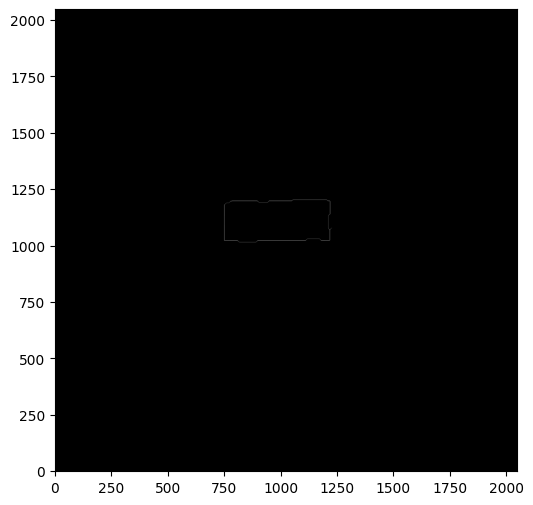

In [24]:
centerline_dist = np.where(centerline, dist_transform, 0)

plt.figure(figsize=(6, 6))
plt.imshow(centerline_dist, origin='lower', cmap='gray')
plt.show()

In [25]:
LEFT_START_Y = map_img.shape[0] // 2 - 3

NON_EDGE = 0.0
left_start_y, left_start_x = LEFT_START_Y, 0

while (centerline_dist[left_start_y][left_start_x] == NON_EDGE): 
	left_start_x += 1

print(f"Starting position for left edge: {left_start_x}, {left_start_y}")

Starting position for left edge: 751, 1021


In [26]:
import sys
sys.setrecursionlimit(20000)


visited = {}
centerline_points = []
track_widths = []

DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
# DIRECTIONS = [(0, -1), (-1, 0),  (0, 1), (1, 0), (-1, 1), (-1, -1), (1, 1), (1, -1) ]

starting_point = (left_start_x, left_start_y)

def depth_first_search(point):
	if (point in visited): return
	visited[point] = True
	centerline_points.append(np.array(point))
	track_widths.append(np.array([centerline_dist[point[1]][point[0]], centerline_dist[point[1]][point[0]]]))

	for direction in DIRECTIONS:
		if (centerline_dist[point[1] + direction[1]][point[0] + direction[0]] != NON_EDGE and (point[0] + direction[0], point[1] + direction[1]) not in visited):
			depth_first_search((point[0] + direction[0], point[1] + direction[1]))

depth_first_search(starting_point)

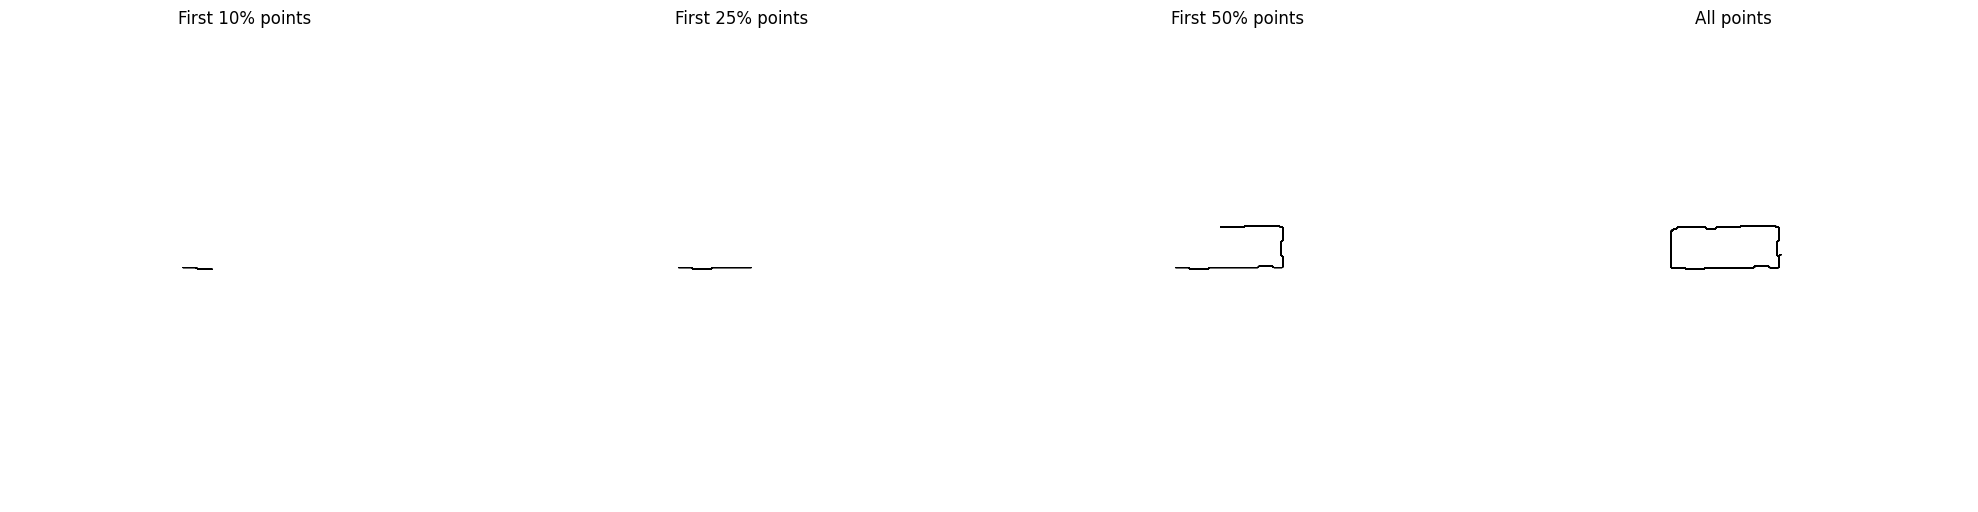

In [27]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

centerline_img = np.zeros_like(map_img)
for x,y in centerline_points[:len(centerline_points)//10]:
	centerline_img[y][x] = 255
ax1.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax1.set_title("First 10% points")

centerline_img = np.zeros_like(map_img)
for x,y in centerline_points[:len(centerline_points)//4]:
	centerline_img[y][x] = 255
ax2.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax2.set_title("First 25% points")

centerline_img = np.zeros_like(map_img)
for x,y in centerline_points[:int(len(centerline_points)/1.4)]:
	centerline_img[y][x] = 255
ax3.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax3.set_title("First 50% points")

centerline_img = np.zeros_like(map_img)
for x,y in centerline_points:
	centerline_img[y][x] = 1000
ax4.imshow(centerline_img, cmap='Greys', vmax=1, origin='lower')
ax4.set_title("All points")
fig.tight_layout()

In [28]:
track_widths_np = np.array(track_widths)
waypoints_np = np.array(centerline_points)

data = np.concatenate((waypoints_np, track_widths_np), axis=1)

In [29]:
with open(map_yaml_path, 'r') as yaml_file:
    try:
        map_metadata = yaml.safe_load(yaml_file)
        map_resolution = map_metadata['resolution']
        origin = map_metadata['origin']
    except yaml.YAMLError as e:
        print(e)

orig_x = origin[0]
orig_y = origin[1]

transformed_data = data
transformed_data *= map_resolution
transformed_data += np.array([orig_x, orig_y, 0, 0])
transformed_data -= np.array([0, 0, TRACK_WIDTH_MARGIN, TRACK_WIDTH_MARGIN])

skip_points = 3 # Tune this for optimization
transformed_data = transformed_data[::skip_points]

In [30]:
with open(f"../tracks/{MAP_NAME}.csv", 'wb') as fh:
    np.savetxt(fh, transformed_data, fmt='%0.4f', delimiter=',', header='x_m,y_m,w_tr_right_m,w_tr_left_m')

In [33]:
centerline_data = pd.read_csv(f"../tracks/{MAP_NAME}.csv")

x_center = centerline_data["# x_m"].values
y_center = centerline_data["y_m"].values

x_center -= orig_x
y_center -= orig_y

x_center /= map_resolution
y_center /= map_resolution

optim = False # Toggle this based on optim availability

if optim:
    optim_data = pd.read_csv(f"../tracks/{MAP_NAME}.csv", header=0, names=["x", "y", "vel"])
    mincurv_data = pd.read_csv(f"../tracks/{MAP_NAME}_mincurv.csv", header=0, names=["x", "y", "vel"])

    x_optim, x_mincurv = optim_data["x"].values, mincurv_data["x"].values
    y_optim, y_mincurv = optim_data["y"].values, mincurv_data["y"].values

    x_optim -= orig_x
    y_optim -= orig_y
    x_mincurv -= orig_x
    y_mincurv -= orig_y

    x_optim /= map_resolution
    y_optim /= map_resolution
    x_mincurv /= map_resolution
    y_mincurv /= map_resolution

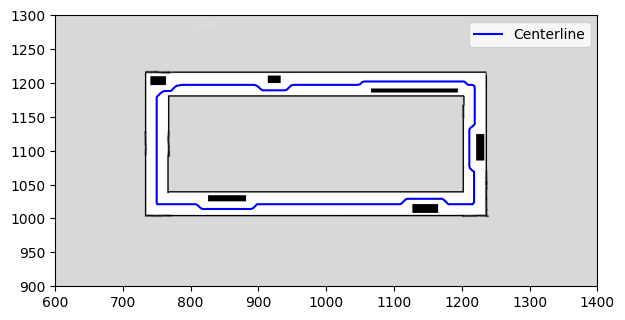

In [34]:
plt.figure(figsize=(7, 7))
plt.imshow(raw_map_img, cmap="gray", origin="lower")
plt.plot(x_center, y_center, 'b', label="Centerline")
if optim:
    plt.plot(x_optim, y_optim, 'r--', label="Min Time Raceline")
    plt.plot(x_mincurv, y_mincurv, 'g--', label="Min Curv Raceline")
plt.legend()
plt.xlim(600, 1400)
plt.ylim(900, 1300)
plt.show()

In [39]:
from PIL import Image

In [35]:
for i in range(0, len(x_center), 10):
    some_x, some_y = x_center[i], y_center[i]

    region_x, region_y = 30, 30
    left, right = some_x - region_x, some_x + region_x
    upper, lower = some_y - region_y, some_y + region_y

    map_img = Image.fromarray(raw_map_img)
    cropped_img = np.array(map_img.crop((left, upper, right, lower)))

    H, W = cropped_img.shape
    cropped_img = cropped_img.reshape(H // 6, 6, W // 6, 6). max(axis=(1, 3))
    print(cropped_img.flatten().shape)
    break

    plt.imshow(cropped_img, cmap="gray", origin="lower")
    plt.show()

(100,)


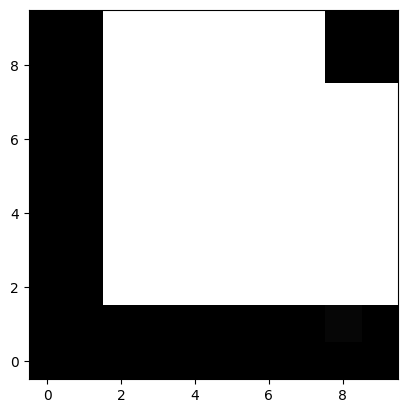

In [36]:
# plt.figure(figsize=(7, 7))
# plt.imshow(raw_map_img, cmap="gray", origin="lower")
plt.imshow(cropped_img, cmap="gray", origin="lower")
# plt.plot(some_x, some_y, 'ro')
plt.show()